In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC

from Pélec_04_fonctions import visuPCA

write_data = True

In [31]:
BEB = pd.read_csv('BEB.csv')

BEBM = BEB.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'])
SiteEnergyUse = np.array(BEB['SiteEnergyUse(kBtu)']).reshape(-1, 1)
TotalGHGEmissions = np.array(BEB.TotalGHGEmissions).reshape(-1, 1)

BEBM_train, BEBM_test, SiteEnergyUse_train, SiteEnergyUse_test = train_test_split(
    BEBM, SiteEnergyUse, test_size=.2)


In [32]:
# Scaler moins sensible aux outlier d'après la doc
scaler = RobustScaler()


In [33]:
# ACP sur toutes les colonnes
numPCA = BEBM.select_dtypes('number').drop(columns='DataYear').dropna().values
RobPCA = make_pipeline(StandardScaler(), PCA())
components = RobPCA.fit_transform(numPCA)
pca = RobPCA.named_steps['pca']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)


In [34]:
# visualisation de la variance expliquée de chaque composante (cumulée)
exp_var_cum = np.cumsum(pca.explained_variance_ratio_)
fig = px.area(x=range(1, exp_var_cum.shape[0] + 1),
              y=exp_var_cum,
              labels={
                  'x': 'Composantes',
                  'y': 'Variance expliquée cumulée'
              })
fig.update_layout(title='Scree plot')
fig.show()
if write_data is True:
    fig.write_image('./Figures/ScreePlot.pdf', height=300)


In [35]:
# création des graphiques
for a1, a2 in [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]:
    fig = visuPCA(
        BEBM.select_dtypes('number').drop(columns='DataYear').dropna(),
        pca,
        components,
        loadings, [(a1, a2)],
        color=None)
    fig.show('browser')
    if write_data is True:
        fig.write_image('./Figures/PCAF{}F{}.pdf'.format(a1 + 1, a2 + 1),
                        width=1100,
                        height=1100)


In [36]:
# modèle régression linéaire
pipeLR = make_pipeline(scaler, linear_model.LinearRegression())

pipeLR.fit(BEBM_train, SiteEnergyUse_train)

SiteEnergyUse_pred = pipeLR.predict(BEBM_test)

LRr2 = metrics.r2_score(SiteEnergyUse_test, SiteEnergyUse_pred)
print("r2 :", LRr2)
LRrmse = metrics.mean_squared_error(SiteEnergyUse_test,
                                     SiteEnergyUse_pred,
                                     squared=False)
print("rmse :", LRrmse)


r2 : -0.0028621017442564956
rmse : 15012338.294829244


In [37]:
# modèle kNN
pipekNN = make_pipeline(scaler, KNeighborsRegressor(n_jobs=-1))

# Fixer les valeurs des hyperparamètres à tester
n_neighbors = np.linspace(10, 100, dtype=int)


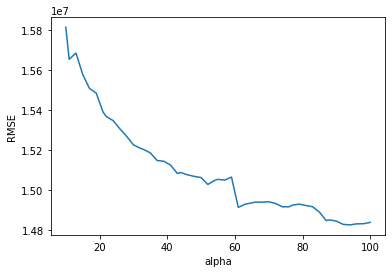

In [38]:
errors = []
for n in n_neighbors:
    pipekNN.set_params(kneighborsregressor__n_neighbors=n)
    pipekNN.fit(BEBM_train, SiteEnergyUse_train)
    errors.append(
        metrics.mean_squared_error(SiteEnergyUse_test,
                                       pipekNN.predict(BEBM_test),
                                       squared=False))

# graph rmse
ax = plt.gca()
ax.plot(n_neighbors, errors)
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.axis('tight')
plt.show()


In [39]:
param_grid = {'kneighborsregressor__n_neighbors': n_neighbors}
# optimisation score
score = ['r2', 'neg_mean_squared_error']

# Classifieur kNN avec recherche d'hyperparamètre par validation croisée
gridpipekNN = GridSearchCV(
    pipekNN,  # un classifieur kNN
    param_grid,  # hyperparamètres à tester
    cv=5,  # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
    refit='neg_mean_squared_error',
    n_jobs=-1)

# Optimisation du classifieur sur le jeu d'entraînement
gridpipekNN.fit(BEBM_train, SiteEnergyUse_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor(n_jobs=-1,
                                                            n_neighbors=100))]),
             n_jobs=-1,
             param_grid={'kneighborsregressor__n_neighbors': array([ 10,  11,  13,  15,  17,  19,  21,  22,  24,  26,  28,  30,  32,
        33,  35,  37,  39,  41,  43,  44,  46,  48,  50,  52,  54,  55,
        57,  59,  61,  63,  65,  66,  68,  70,  72,  74,  76,  77,  79,
        81,  83,  85,  87,  88,  90,  92,  94,  96,  98, 100])},
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error'])

In [40]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpipekNN.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	kneighborsregressor__n_neighbors: 100


In [41]:
# Erreur kNN
SiteEnergyUse_predkNN = gridpipekNN.predict(BEBM_test)
r2kNN = metrics.r2_score(SiteEnergyUse_test, SiteEnergyUse_predkNN)
print(r2kNN)
rmsekNN = metrics.mean_squared_error(SiteEnergyUse_test,
                                     SiteEnergyUse_predkNN,
                                     squared=False)
print(rmsekNN)


0.02027167332081481
14838177.606516013


In [42]:
#modèle Rige
piperige = make_pipeline(scaler, linear_model.Ridge())

alphas = np.logspace(3, 7, 1000)
param_grid = {'ridge__alpha': alphas}


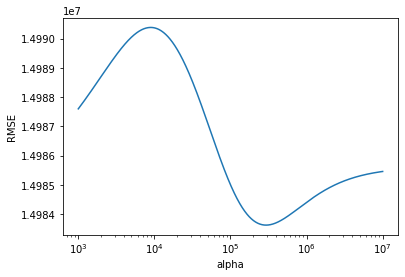

In [43]:
errors = []
for a in alphas:
    piperige.set_params(ridge__alpha=a)
    piperige.fit(BEBM_train, SiteEnergyUse_train)
    errors.append(
        metrics.mean_squared_error(SiteEnergyUse_test,
                                   piperige.predict(BEBM_test),
                                   squared=False))

# graph rmse
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.axis('tight')
plt.show()


In [44]:
# Validation croisée
gridpiperige = GridSearchCV(piperige,
                            param_grid,
                            cv=5,
                            scoring=score,
                            refit='neg_mean_squared_error',
                            n_jobs=-1)

gridpiperige.fit(BEBM_train, SiteEnergyUse_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('ridge', Ridge(alpha=10000000.0))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([1.00000000e+03, 1.00926219e+03, 1.01861017e+03, 1.02804473e+03,
       1.03756668e+03, 1.04717682e+03, 1.05687597e+03, 1.06666496e+03,
       1.07654461e+03, 1.08651577e+03, 1.09657929e+03, 1.10673602e+03,
       1.11698682e+03...
       8.39312950e+06, 8.47086827e+06, 8.54932707e+06, 8.62851257e+06,
       8.70843150e+06, 8.78909065e+06, 8.87049689e+06, 8.95265713e+06,
       9.03557835e+06, 9.11926760e+06, 9.20373200e+06, 9.28897872e+06,
       9.37501502e+06, 9.46184819e+06, 9.54948564e+06, 9.63793480e+06,
       9.72720319e+06, 9.81729841e+06, 9.90822810e+06, 1.00000000e+07])},
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error'])

In [45]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpiperige.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	ridge__alpha: 33229.325163989684


In [46]:
# Erreur rigde
SiteEnergyUse_predrige = gridpiperige.predict(BEBM_test)
r2rige = metrics.r2_score(SiteEnergyUse_test, SiteEnergyUse_predrige)
print(r2rige)
rmserige = metrics.mean_squared_error(SiteEnergyUse_test,
                                     SiteEnergyUse_predrige,
                                     squared=False)
print(rmserige)


0.0003345089619801733
14988393.376044666


In [47]:
# modèle elastic net
pipeEN = make_pipeline(scaler, linear_model.ElasticNet())

alphas = np.logspace(-3, 3, 1000)
param_grid = {'elasticnet__alpha': alphas}


/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e+17, tolerance: 6.883e+13

/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e+17, tolerance: 6.883e+13

/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

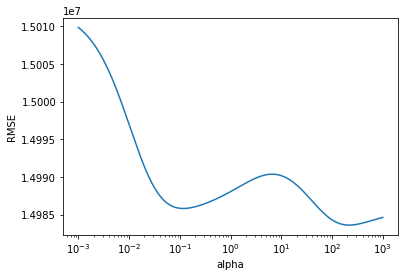

In [48]:
errors = []
for a in alphas:
    pipeEN.set_params(elasticnet__alpha=a)
    pipeEN.fit(BEBM_train, SiteEnergyUse_train)
    errors.append(
        metrics.mean_squared_error(SiteEnergyUse_test,
                                   pipeEN.predict(BEBM_test),
                                   squared=False))

# graph rmse
ax = plt.gca()
ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.axis('tight')
plt.show()


In [49]:
# Validation croisée
gridpipeEN = GridSearchCV(pipeEN,
                          param_grid,
                          cv=5,
                          scoring=score,
                          refit='neg_mean_squared_error',
                          n_jobs=-1)

gridpipeEN.fit(BEBM_train, SiteEnergyUse_train)


/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.774e+17, tolerance: 5.663e+13
  model = cd_fast.enet_coordinate_descent(
/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e+17, tolerance: 4.409e+13
  model = cd_fast.enet_coordinate_descent(
/home/lancelot/Documents/FormationDataScientist/P4/.env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the nu

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('elasticnet',
                                        ElasticNet(alpha=1000.0))]),
             n_jobs=-1,
             param_grid={'elasticnet__alpha': array([1.00000000e-03, 1.01392541e-03, 1.02804473e-03, 1.04236067e-03,
       1.05687597e-03, 1.07159340e-03, 1.08651577e-03, 1.10164595e-03,
       1.11698682e-03, 1.13254132e-03, 1.14831241e-03, 1.16430313e-03,
       1.1...
       7.68928372e+02, 7.79636013e+02, 7.90492762e+02, 8.01500696e+02,
       8.12661920e+02, 8.23978568e+02, 8.35452806e+02, 8.47086827e+02,
       8.58882856e+02, 8.70843150e+02, 8.82969996e+02, 8.95265713e+02,
       9.07732653e+02, 9.20373200e+02, 9.33189772e+02, 9.46184819e+02,
       9.59360829e+02, 9.72720319e+02, 9.86265846e+02, 1.00000000e+03])},
             refit='neg_mean_squared_error',
             scoring=['r2', 'neg_mean_squared_error'])

In [50]:
# Afficher l'hyperparamètre optimal
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
best_parameters = gridpipeEN.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
	elasticnet__alpha: 30.653952950565298


In [51]:
# Erreur ElasticNet
SiteEnergyUse_predEN = gridpipeEN.predict(BEBM_test)
r2EN = metrics.r2_score(SiteEnergyUse_test, SiteEnergyUse_predEN)
print(r2EN)
rmseEN = metrics.mean_squared_error(SiteEnergyUse_test,
                                     SiteEnergyUse_predEN,
                                     squared=False)
print(rmseEN)


0.00042397160407980916
14987722.68605597
